# Predicting Clutch Goalscorers in the NHL using Machine Learning Techniques

In this project, I explored various machine learning techniques to determine the best performing NHL forwards in close and tied games (often referred to as "clutch" moments). The process involved several key steps:

### 1. Identifying Correct Sources of Data
I needed to scrape data from the NHL API and Natural Stat Trick. The NHL API offers a good foundation for player bios and common goal statistics. However. Natural Stat Trick provided many advanced metrics as well as goals scored by players in close and tied games.

### 2. Data Cleaning
I merged data from the NHL API and Natural Stat Trick, then ensured the data was accurate and filtered appropriately.

### 3. Establishing a Definition of Clutch
I computed a "clutch score" for players by weighting the number of goals they scored in close and tied situations as well as in overtime.

### 4. Building a Classification Model
I attempted to classify players as "clutch" and "non-clutch" by setting thresholds for the clutch score. I used metrics such as expected goals, scoring chances, and other advanced statistics as features. The model was trained on data from the 2020-2021 to 2022-2023 NHL seasons. While the model was successful in identifying elite players and those below average, it struggled with players who fell near the classification boundaries, where small differences in their stats made it difficult to confidently label them as clutch or non-clutch.

### 5. Switching to a Regression Model
I realized that linear regression was a more feasible approach since many of the features were strongly correlated with a clutch score. It would, therefore, be easier to predict a player's clutch score rather than assigning the player an ambiguous label.  
I refined the model by using Ridge regression and performed cross-validation to ensure there was no overfitting.

### 6. Dealing with Outliers
I used Cook's Distance to identify influential points. I discovered that the model underpredicted the clutch score of elite players because their feature stats set a "ceiling" for their clutch ability. The model also overestimated some elite players who had strong underlying metrics but did not perform well in clutch games. In addition, the model struggled with below-average players who scored clutch goals at a rate that did not match their advanced stats.  
This prompted me to use a log transformation, which enabled the model to generate better predictions for elite players and significantly reduced the number of influential points. However, this transformation caused some inaccuracies for below-average players, as it amplified the difference between predicted and actual clutch scores for players with low stats.

### 7. Using the Model on a Final Test Set
After I was satisfied with the model, I used it to predict the clutch score of players based on their stats from the start of the 2023-2024 season to the current point of the 2024-2025 season.  
In the coming weeks, I plan to deploy the model and connect it to a Power BI dashboard, which will provide real-time updates of a player's current clutch score and their predicted clutch score.


### Imports
These are the necessary imports for the project.

In [66]:
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General imports
import time
import math
import json
import requests
import functools as ft
import scipy.stats as stats

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# XGBoost and machine learning
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, PrecisionRecallDisplay, make_scorer
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA

# Hyperparameter tuning with Skopt
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

### NHL API
The following snippet of code scrapes data from the NHL API for the 2020-2021 to 2022-2023 NHL seasons, while accounting for any issues that may occur when connecting to the API. It also combines a player's stats across these seasons.

In [67]:
all_seasons = []

for season in range(2020, 2023):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)

Successfully fetched data for season 2020-2021
Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023


### Cleaning the Scraped NHL API Data
The next step is to clean the data properly:
-  Only forwards are included since defensemen score at different rates. 
-  I kept players who appeared in at least 60 games across the three seasons (approximately 20 games each season). This ensured that there was a sufficient sample size for each player.
-  Finally, some columns are renamed to maintain a consistent naming format.

In [68]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 60)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df.rename(columns={'timeOnIcePerGame': 'time_on_ice_per_game'}, inplace=True)


### Scraping Data from Natural Stat Trick
The code below establishes URL links for the pages needed from Natural Stat Trick.

In [69]:
start_season = "20202021"
end_season = "20222023"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

### Scraping Data from Natural Stat Trick
The code below scrapes data from Natural Stat Trick and stores the data for each page in a dataframe.

In [70]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

### Cleaning Data from Natural Stat Trick
After scraping the data from Natural Stat Trick, only relevant columns are included for each dataframe. These dataframes are then merged into one dataframe containing all statistics from Natural Stat Trick.

Similar to the NHL API data, only players who have played at least 60 games are included.

The dataframes do not need to be filtered for forwards because it was easier to do this through the URLs.


In [71]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts', 'iCF', 'Rebounds Created']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 60]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)

### Standardize Player Names
Some players from Natural Stat Trick have different names compared to the NHL API. It is important to use standard names in both dataframes before merging them.


In [72]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Thomas Novak"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Tommy Novak"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [73]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,Rush Attempts,iCF,Rebounds Created
0,Joe Thornton,78,1,3,1,10,68,7.27,91,72,36,5,110,10
2,Jason Spezza,125,3,4,7,22,178,17.16,243,155,66,13,313,24
6,Eric Staal,125,3,2,8,19,188,21.77,253,206,106,11,328,28
7,Jeff Carter,209,10,11,11,49,493,51.65,618,450,236,36,781,89
8,Dustin Brown,113,5,5,6,26,275,30.32,364,241,122,12,445,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,Matty Beniers,90,6,4,8,27,166,22.91,244,174,85,13,306,14
755,Cole Sillinger,143,3,5,6,19,241,27.17,338,276,115,7,433,36
758,Wyatt Johnston,82,4,4,8,24,160,18.92,207,192,94,8,281,35
759,Mason McTavish,89,2,6,5,19,173,22.67,231,174,92,8,285,35


In [74]:
nhl_api_df

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,time_on_ice_per_game
0,8466138,Joe Thornton,C,78,20,0,744.77870
1,8469455,Jason Spezza,C,125,33,0,653.25985
2,8470595,Eric Staal,C,125,23,1,868.72430
3,8470604,Jeff Carter,C,209,55,2,958.84570
4,8470606,Dustin Brown,R,113,33,0,970.80450
...,...,...,...,...,...,...,...
486,8482665,Matty Beniers,C,90,39,1,1020.96250
487,8482705,Cole Sillinger,C,143,23,0,810.29235
488,8482740,Wyatt Johnston,C,82,17,0,928.90240
489,8482745,Mason McTavish,C,89,27,0,853.62010


### Merging the Data
The dataframes containing the information from the NHL API and Natural Stat Trick are merged.

In [75]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'inner')

In [76]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,time_on_ice_per_game,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,Rush Attempts,iCF,Rebounds Created
0,8466138,Joe Thornton,C,78,20,0,744.77870,78,1,3,1,10,68,7.27,91,72,36,5,110,10
1,8469455,Jason Spezza,C,125,33,0,653.25985,125,3,4,7,22,178,17.16,243,155,66,13,313,24
2,8470595,Eric Staal,C,125,23,1,868.72430,125,3,2,8,19,188,21.77,253,206,106,11,328,28
3,8470604,Jeff Carter,C,209,55,2,958.84570,209,10,11,11,49,493,51.65,618,450,236,36,781,89
4,8470606,Dustin Brown,R,113,33,0,970.80450,113,5,5,6,26,275,30.32,364,241,122,12,445,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,8482665,Matty Beniers,C,90,39,1,1020.96250,90,6,4,8,27,166,22.91,244,174,85,13,306,14
486,8482705,Cole Sillinger,C,143,23,0,810.29235,143,3,5,6,19,241,27.17,338,276,115,7,433,36
487,8482740,Wyatt Johnston,C,82,17,0,928.90240,82,4,4,8,24,160,18.92,207,192,94,8,281,35
488,8482745,Mason McTavish,C,89,27,0,853.62010,89,2,6,5,19,173,22.67,231,174,92,8,285,35


### Null values
Check that there are no Null values after merging.

In [77]:
merged_clutch_goals = merged_clutch_goals.fillna(0)
null_rows = merged_clutch_goals[merged_clutch_goals.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, assists, ot_goals, time_on_ice_per_game, GP, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, Rush Attempts, iCF, Rebounds Created]
Index: []


### Changing Columns
Drop the "GP" column since it existed in both previously merged dataframes.

Compute per game stats to accurately compare players.

In [80]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)
columns = ['ot_goals', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'Rebounds Created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


### Clutch Score
After cleaning the data, we can now compute a weighted clutch score for each player.
- Goals scored when tied and down by one are given the most weighting since these are the most representative of high-pressure situations.
- Goals scored when up by one are still close situations but may not be as "clutch" compared to goals scored when tied and down by one.
- OT goals are also given a smaller weight, since they occur infrequently compared to other goals. They are also only scored during 3v3 play, which differs from the traditional v5.


In [83]:
merged_clutch_goals['clutch_score'] = 0.3 * merged_clutch_goals['goals_when_tied_per_game'] + 0.3 * merged_clutch_goals['goals_down_by_one_per_game'] + 0.2 * merged_clutch_goals['goals_up_by_one_per_game'] + 0.2 * merged_clutch_goals['ot_goals_per_game']

### Rankings Players Based on their Clutch Score
All scores are multiplied by 100 to make them more interpretable.
The scores are then ranked and the top 20 players are shown below.

In [86]:
merged_clutch_goals['clutch_score'] *= 100
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
334,Auston Matthews,1467.0,1.0
253,David Pastrnak,1376.0,2.0
320,Kirill Kaprizov,1300.0,3.0
283,Connor McDavid,1284.0,4.0
239,Leon Draisaitl,1241.0,5.0
54,Max Pacioretty,1174.0,6.0
399,Jason Robertson,1159.0,7.0
241,William Nylander,1121.0,8.0
219,Aleksander Barkov,1103.0,9.0
361,Tage Thompson,1093.0,10.0


### Distribution of Clutch Scores
As shown by the historgram below, the data for clutch scores is right skewed. Most players have a below average clutch score and there are a small number of elite players.

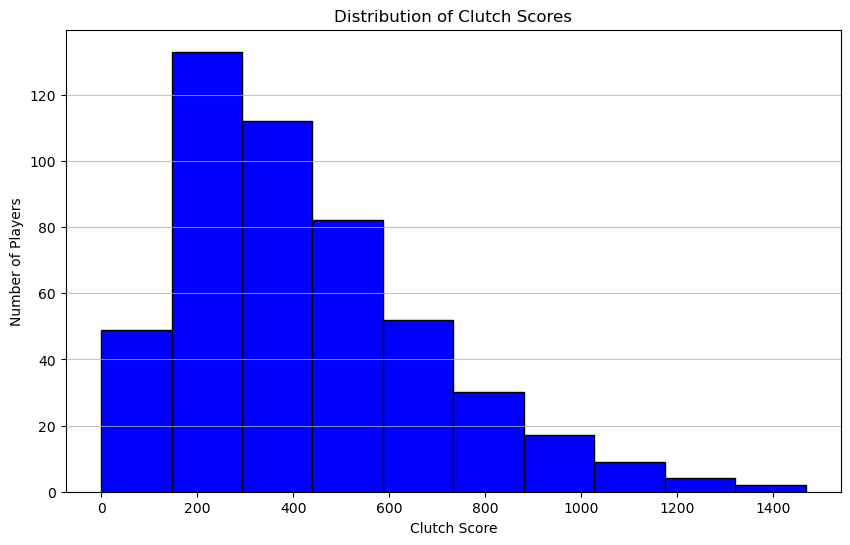

In [93]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Clutch Score")
plt.ylabel("Number of Players")
plt.title("Distribution of Clutch Scores")
plt.show()

### Threshold for Clutch Scores
It makes sense to label "clutch" goalscorers as a higher percentile of a data. Thus, all players who had a clutch score in the 85th percentile were in the positive class.
This approach already highlights the potential shortcomings of classification for this project. Is a player in the 80 to 84th percentile suddenly not "clutch"? Even if we used a multiclass classification approach, how can we distinguish between players who fall near the boundarie?


In [94]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)
threshold_high = merged_clutch_goals['clutch_score'].quantile(0.7)
threshold_average = merged_clutch_goals['clutch_score'].quantile(0.5)


def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

### Class Imbalance
Due to the right skew distribution of the data, there are very few goalscorers classified as "clutch.

In [95]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    416
1     74
Name: count, dtype: int64

In [ ]:
### Setting up a Classfication Model


In [20]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game','time_on_ice_per_game']
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [21]:
skf = StratifiedKFold(n_splits=10)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

fit_time          0.075997
score_time        0.022440
test_accuracy     0.888490
test_precision    0.737436
test_recall       0.653571
test_f1           0.629959
dtype: float64

C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise

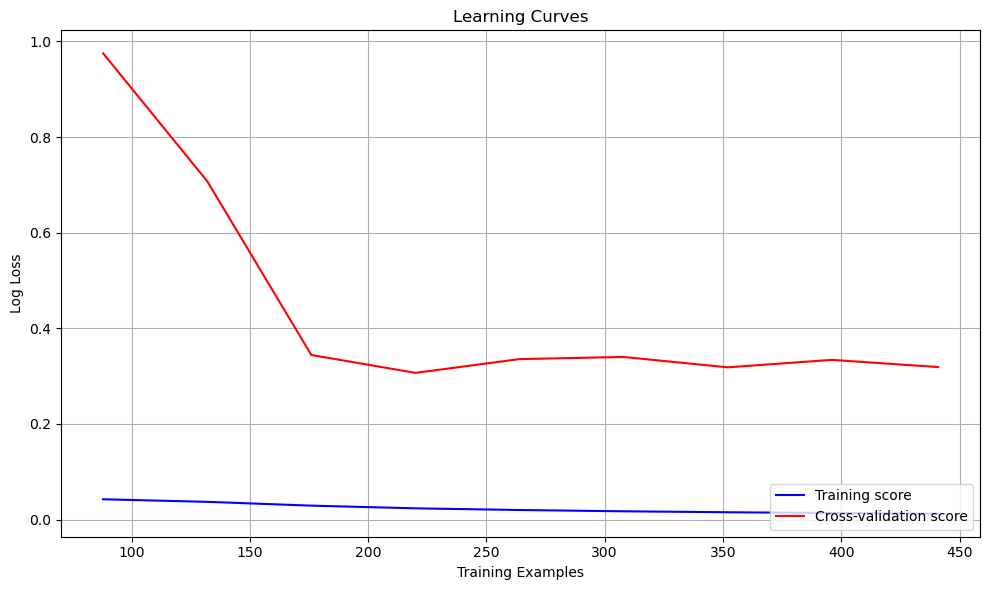

In [22]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss',
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

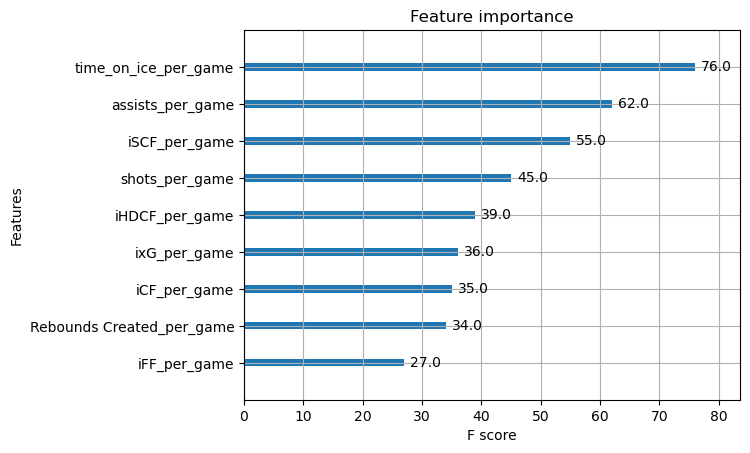

In [23]:
plot_importance(xgb_model)
plt.show()

In [24]:
x_var_adjusted = ['shots_per_game', 'ixG_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals[x_var_adjusted]

In [25]:
param_grid = {
    'max_depth': Integer(2,5),
    'min_child_weight': Integer(2,3), 
    'n_estimators': Integer(200, 300),
    'learning_rate': Real(0.03, 0.04), 
    'reg_alpha': Real(0.75, 1.9),
    'reg_lambda': Real(0.75, 1.9),
    'subsample': Real(0.7, 1), 
    'colsample_bytree': Real(0.7, 1)  
}

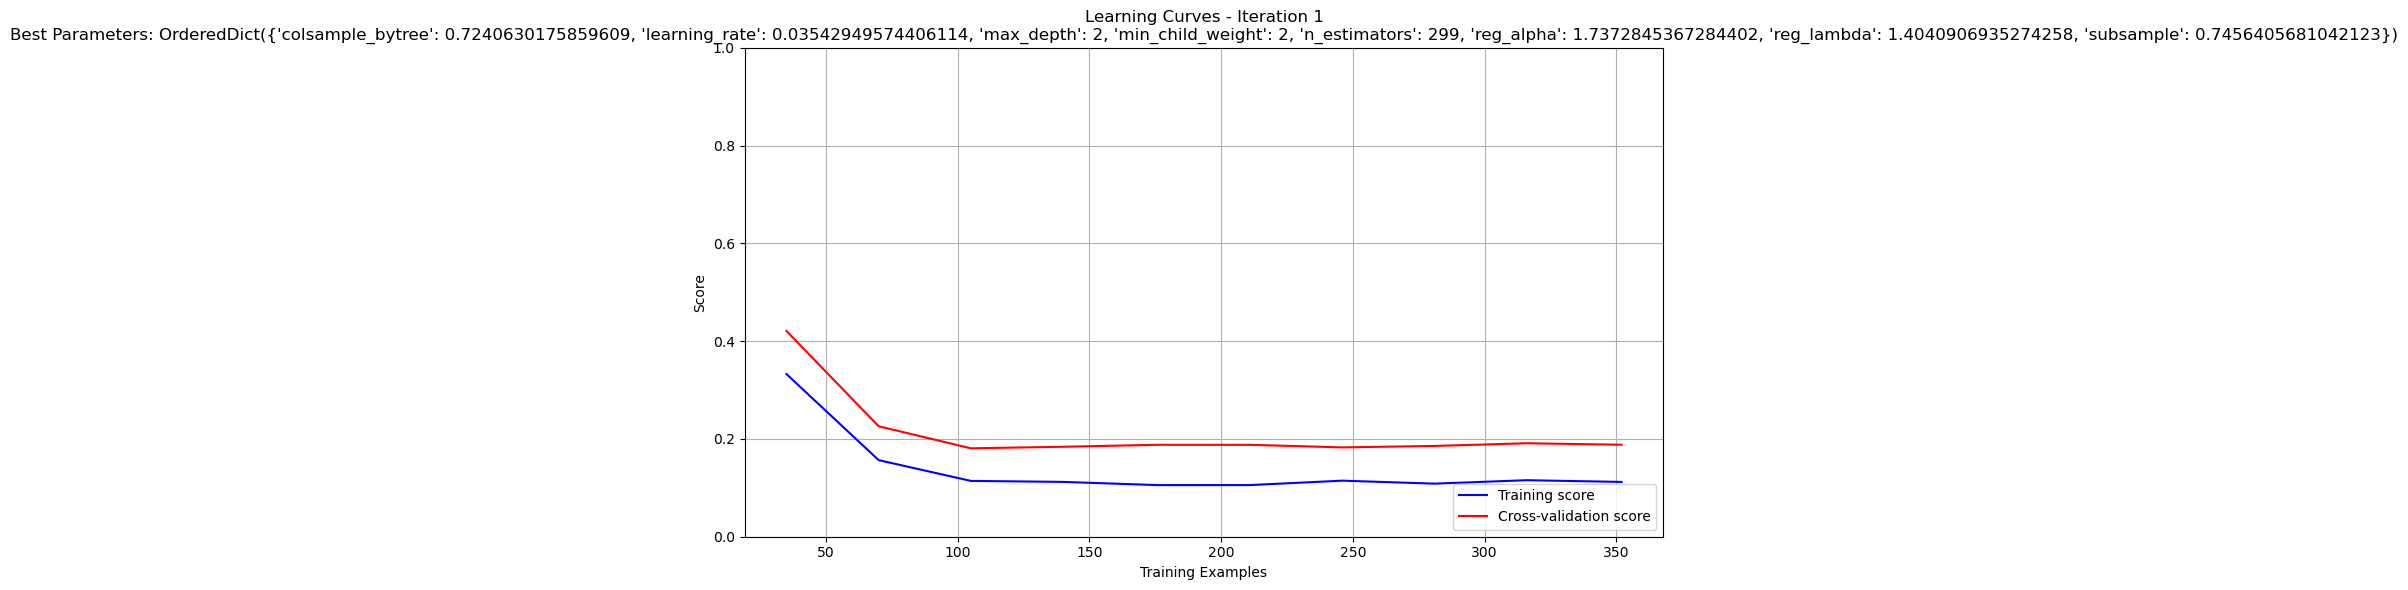

Recall Score:  0.6666666666666666


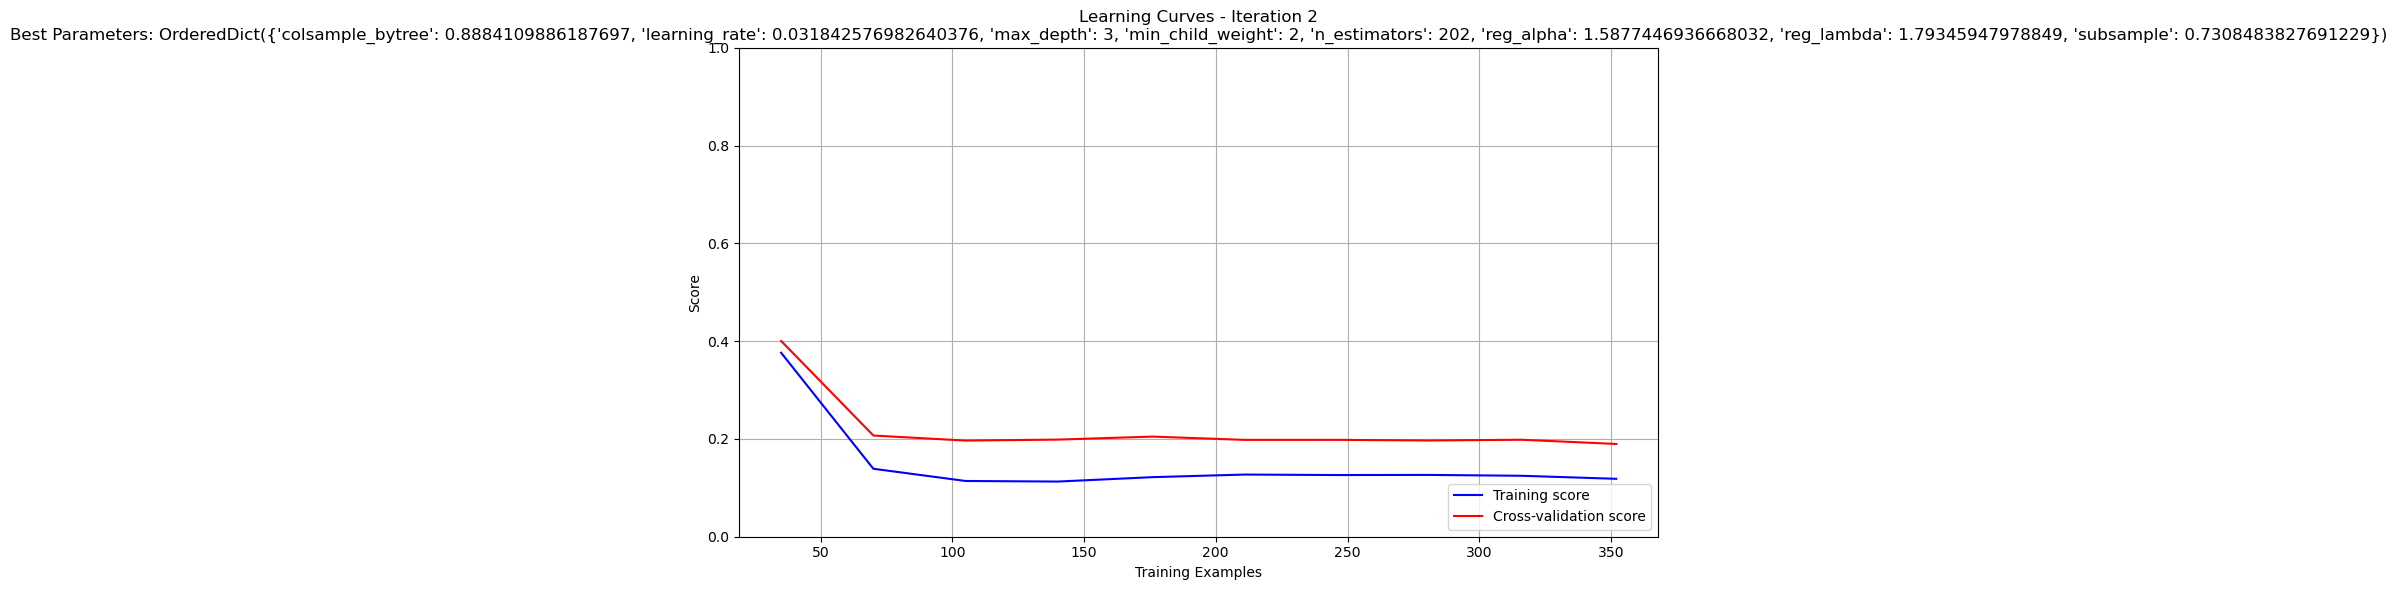

Recall Score:  0.6666666666666666
Average Accuracy: 0.9292929292929293
Average Precision: 0.8391608391608392
Average Recall: 0.6666666666666666
Average F1 Score: 0.7417582417582418
Averaged Hyperparameters:
colsample_bytree      0.806237
learning_rate         0.033636
max_depth             2.500000
min_child_weight      2.000000
n_estimators        250.500000
reg_alpha             1.662515
reg_lambda            1.598775
subsample             0.738244
dtype: float64


In [26]:
cv = StratifiedKFold(n_splits=10)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
best_hyperparams_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(2):
    rs = np.random.randint(1, 1000)

    train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state = rs
    )

    class_weights = compute_sample_weight(class_weight='balanced', y=train_y)
    
    xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss')
    xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

    random_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, scoring= ['recall'], refit='recall', n_jobs = -1)

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  

    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)

    print("Recall Score: ", recall)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    best_hyperparams_list.append(random_search.best_params_)

print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.median(recall_list))
print("Average F1 Score:", np.mean(f1_list))

hyperparams_df = pd.DataFrame(best_hyperparams_list)
averaged_hyperparams = hyperparams_df.mean()
print("Averaged Hyperparameters:")
print(averaged_hyperparams)

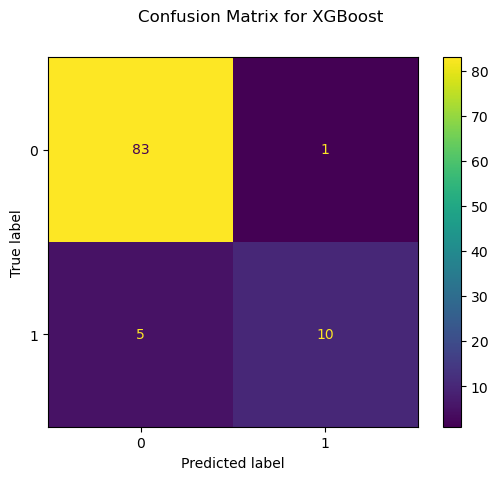

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(test_y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [28]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X= merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

correlation = X.corrwith(y) 
print(correlation)

shots_per_game               0.881640
ixG_per_game                 0.888284
iFF_per_game                 0.885369
iSCF_per_game                0.899731
iHDCF_per_game               0.736754
assists_per_game             0.768798
iCF_per_game                 0.878980
Rebounds Created_per_game    0.772109
time_on_ice_per_game         0.796677
dtype: float64


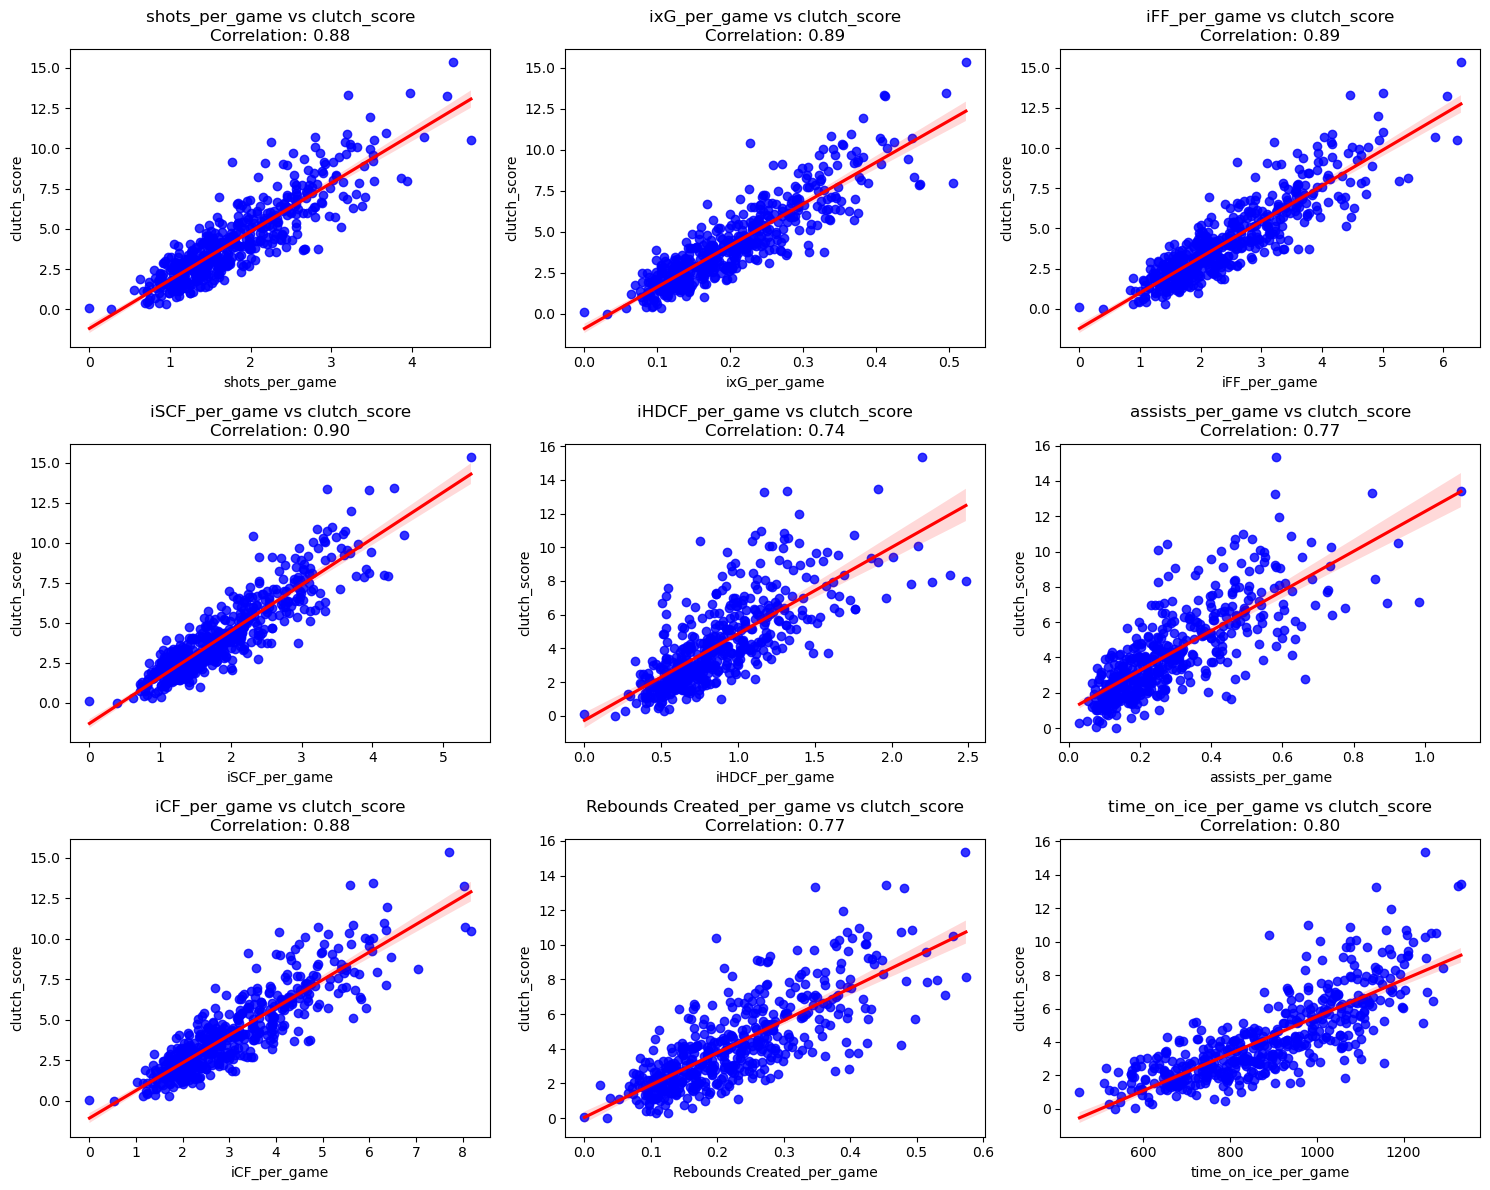

In [29]:
plt.figure(figsize=(15, 12))  

for i, var in enumerate(x_var):
    plt.subplot(3, 3, i+1)
    
    sns.regplot(data=merged_clutch_goals, x=var, y=y, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    
    plt.title(f'{var} vs {y_var}\nCorrelation: {correlation[var]:.2f}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel(y_var)

plt.tight_layout()  
plt.show()

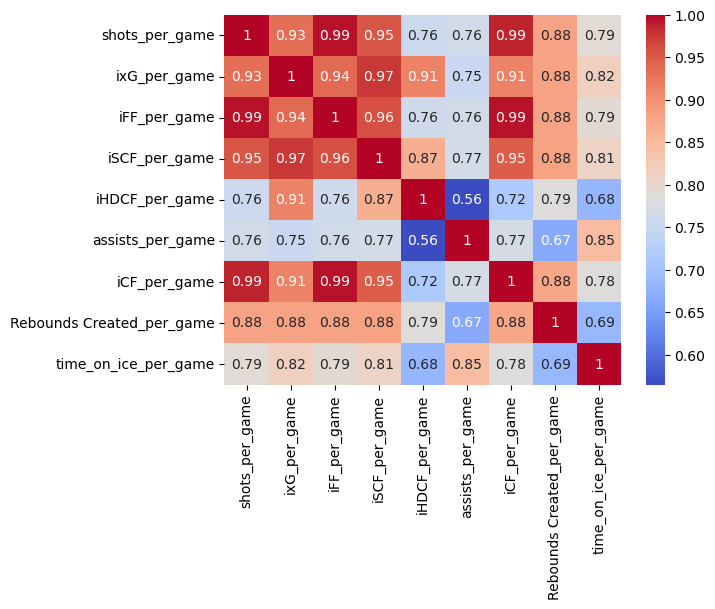

In [30]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

In [31]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals[y_var]

X_scaled = StandardScaler().fit_transform(X_adjusted)

train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

alphas_random = np.random.uniform(0.0001, 1000, 50)

ridge_cv = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv.fit(train_x, train_y)

y_pred = ridge_cv.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))

MSE:  1.0926642666760047
RMSE:  1.0453058244724387
MAE:  0.6454288663472756
R²:  0.8580079598300416
Adjusted R²:  0.8546625976270845


In [32]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, validation_scores = learning_curve(
ridge_cv,
X_scaled,
y, train_sizes = train_sizes, cv = 10,
scoring = 'neg_mean_squared_error')


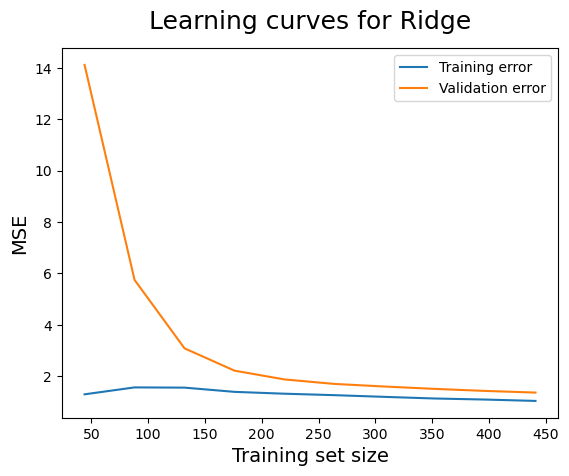

In [33]:
import matplotlib.pyplot as plt

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Ridge', fontsize = 18, y = 1.03)
plt.legend()

In [34]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(60))

All predictions and actual values:
                    Player  Actual  Predicted     Error
246            Jakub Vrana   10.40   5.255362  5.144638
335        Auston Matthews   15.33  12.067892  3.262108
300            Roope Hintz    9.69   7.418623  2.271377
55           Jakub Voracek    2.80   4.809175  2.009175
60          Steven Stamkos    9.70   7.713865  1.986135
171         Filip Forsberg   10.06   8.211396  1.848604
117        Mikael Granlund    2.76   4.604906  1.844906
209       Andre Burakovsky    6.70   4.880675  1.819325
150         Mark Scheifele    9.02   7.327701  1.692299
269          Dakota Joshua    2.89   1.426915  1.463085
310           Jake DeBrusk    7.09   5.675090  1.414910
488         Wyatt Johnston    5.73   4.350956  1.379044
456          Cole Caufield    8.29   6.995793  1.294207
336           Wade Allison    4.13   2.849016  1.280984
224              Bo Horvat    8.68   7.406927  1.273073
78           Alex Chiasson    4.17   2.930946  1.239054
107          

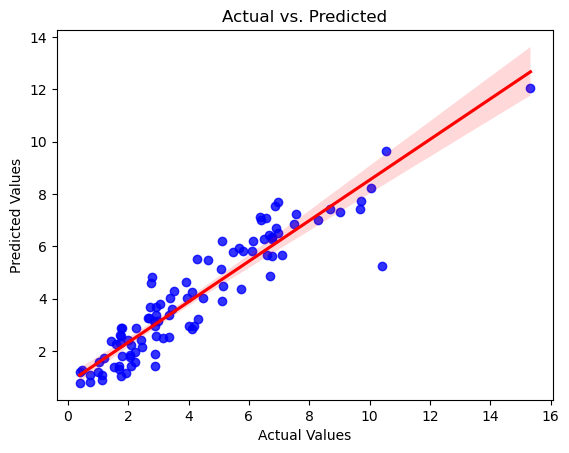

In [35]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

<Axes: xlabel='clutch_score'>

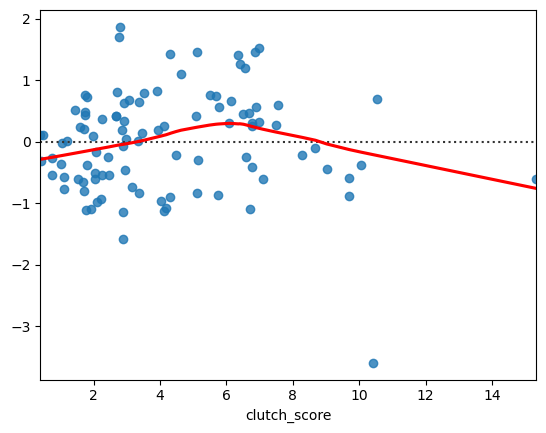

In [36]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))

There are 40 influential points.
Outliers based on Cook's Distance:
                  Player  Actual  Predicted  Cook's Distance
335      Auston Matthews   15.33  12.771322         0.089624
284       Connor McDavid   13.44  12.232692         0.023743
240       Leon Draisaitl   13.33  10.268935         0.058680
254       David Pastrnak   13.27  10.785039         0.042046
321      Kirill Kaprizov   11.97   9.537709         0.014147
54        Max Pacioretty   10.98   8.990213         0.015717
400      Jason Robertson   10.87   7.922492         0.038332
291        Sebastian Aho   10.71   8.534895         0.014174
219     Nathan MacKinnon   10.49  11.853460         0.015769
246          Jakub Vrana   10.40   5.663728         0.042516
220    Aleksander Barkov   10.27   8.658559         0.008965
86         Chris Kreider   10.10   7.466307         0.041567
171       Filip Forsberg   10.06   8.224806         0.013881
362        Tage Thompson   10.05   7.618477         0.013721
300          Roop

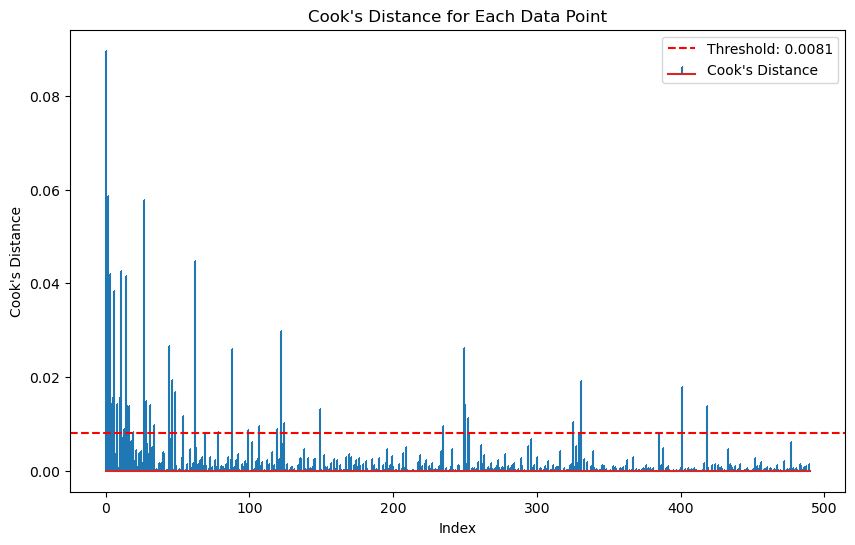

In [37]:
X_with_intercept = sm.add_constant(X_scaled)

ols_model = sm.OLS(y, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()


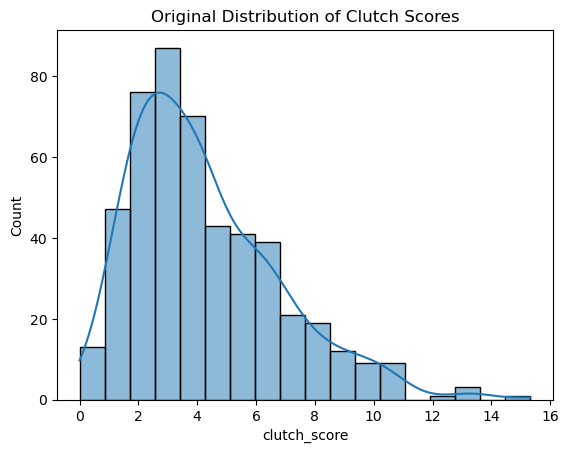

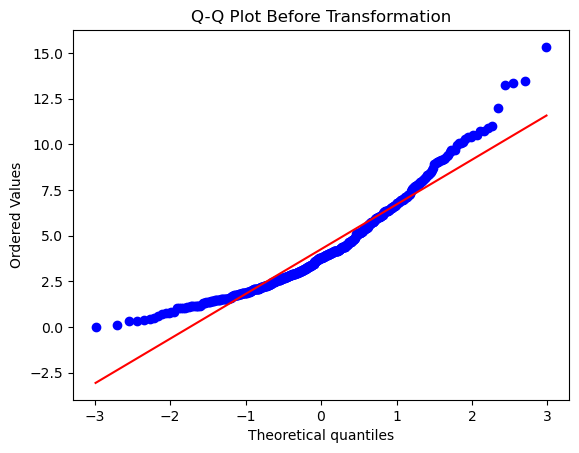

In [38]:
sns.histplot(y, kde=True)
plt.title("Original Distribution of Clutch Scores")
plt.show()

stats.probplot(y, dist="norm", plot=plt)
plt.title("Q-Q Plot Before Transformation")
plt.show()

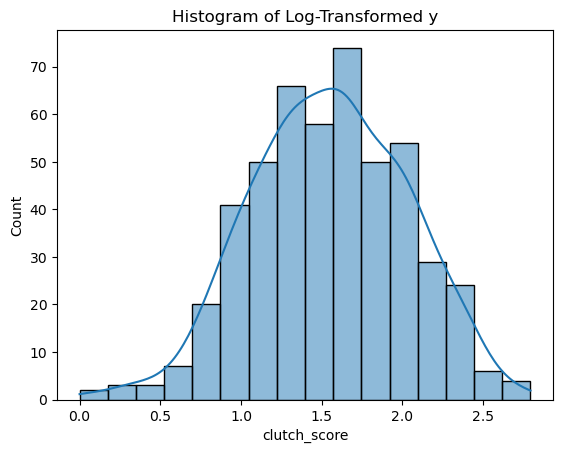

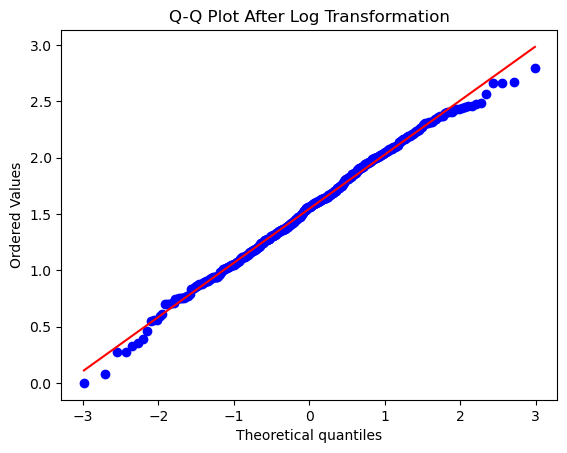

In [39]:
y_log = np.log(y + 1)  

sns.histplot(y_log, kde=True)
plt.title("Histogram of Log-Transformed y")
plt.show()

stats.probplot(y_log, dist="norm", plot=plt)
plt.title("Q-Q Plot After Log Transformation")
plt.show()

In [40]:
epsilon = np.abs(X_scaled.min()) + 1

X_shifted = X_scaled + epsilon

In [41]:
y_log = np.log(y + 1)

X_log = np.log(X_shifted)

train_x, test_x, train_y, test_y = train_test_split(
    X_log, 
    y_log, 
    test_size=0.2, 
    random_state=42
)

alphas_random = np.random.uniform(0.0001, 1000, 50)
ridge_cv_log = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv_log.fit(train_x, train_y)
y_pred = ridge_cv_log.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))


MSE:  0.042772514644137796
RMSE:  0.2068151702466185
MAE:  0.1447316131768479
R²:  0.8485400876213567
Adjusted R²:  0.8449716603663625


In [42]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(55))

All predictions and actual values:
                    Player    Actual  Predicted     Error
246            Jakub Vrana  2.433613   1.728127  0.705486
382        Jake Leschyshyn  0.329304   0.898050  0.568747
59              Jay Beagle  0.392042   0.929955  0.537913
185        Cedric Paquette  0.350657   0.766038  0.415381
209       Andre Burakovsky  2.041220   1.674221  0.366999
269          Dakota Joshua  1.358409   1.004379  0.354030
55           Jakub Voracek  1.335001   1.662511  0.327510
117        Mikael Granlund  1.324419   1.650297  0.325878
192           Jayson Megna  0.548121   0.865838  0.317717
78           Alex Chiasson  1.642873   1.330985  0.311887
181          Teddy Blueger  1.011601   1.321035  0.309434
182           Brock McGinn  1.615420   1.325388  0.290032
24             Darren Helm  0.887891   1.176318  0.288427
276             Jake Evans  1.026042   1.309683  0.283641
300            Roope Hintz  2.369309   2.087420  0.281889
367            Ross Colton  1.809927 

There are 13 influential points.
Outliers based on Cook's Distance:
              Player    Actual  Predicted  Cook's Distance
246      Jakub Vrana  2.433613   1.836474         0.018264
490  Andrei Kuzmenko  2.316488   1.842127         0.019532
377       Mason Shaw  1.401183   1.048715         0.023923
269    Dakota Joshua  1.358409   0.968999         0.018994
474       Jack Quinn  1.316408   1.669466         0.015282
480    Cole Perfetti  1.108563   1.682969         0.025390
6       Ryan Getzlaf  1.040277   1.576280         0.022291
479  Quinton Byfield  0.698135   1.316591         0.028247
484        Nils Aman  0.463734   0.927868         0.022155
59        Jay Beagle  0.392042   0.881137         0.018261
382  Jake Leschyshyn  0.329304   0.896191         0.016835
197  Saku Maenalanen  0.270027   0.866111         0.018049
230    Ross Johnston  0.000000   0.361609         0.014974


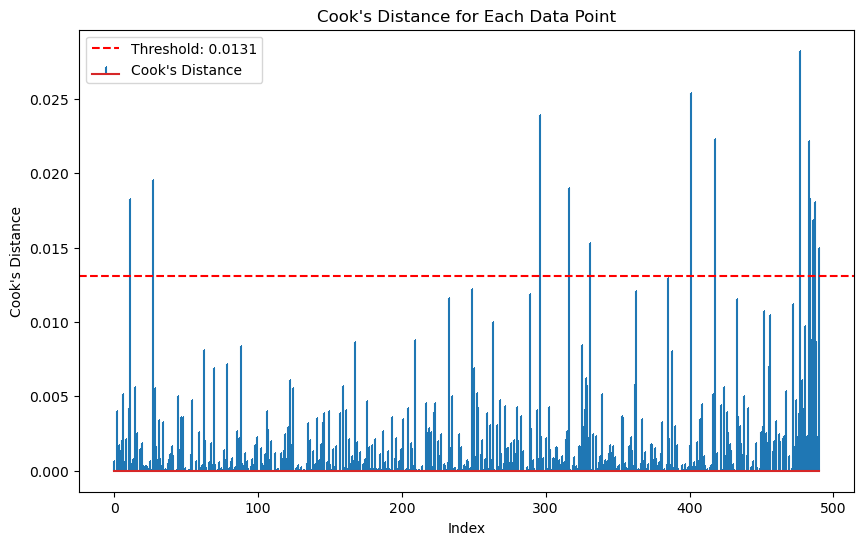

In [43]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / (316-9-1)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

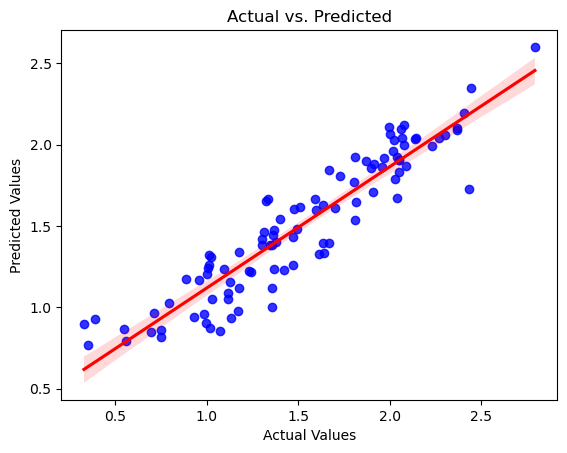

In [44]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

<Axes: xlabel='clutch_score'>

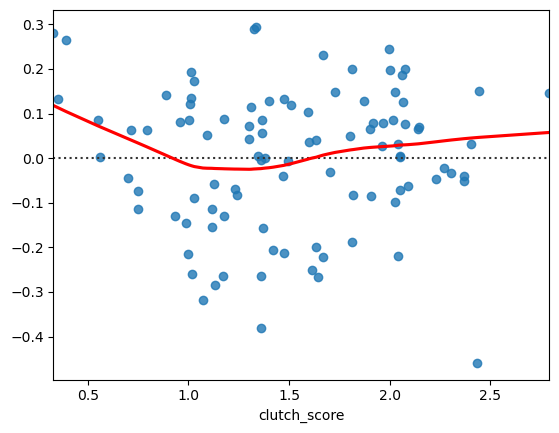

In [45]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))

In [209]:
all_seasons = []

for season in range(2022, 2024):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2022-2023
Successfully fetched data for season 2023-2024
      playerId     skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0      8470595         Eric Staal            C           72       15        0   
1      8470600         Ryan Suter            D          164       37        0   
2      8470604        Jeff Carter            C          151       20        1   
3      8470610        Zach Parise            L          112       18        1   
4      8470613        Brent Burns            D          164       76        1   
...        ...                ...          ...          ...      ...      ...   
1088   8484314       Jiri Smejkal            L           20        1        0   
1089   8484321  Nikolas Matinpalo            D            4        0        0   
1090   8484325    Waltteri Merela            C           19        0        0   
1091   8484326        Patrik Koch            D            1        0        0   
1092   8484911 

In [211]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 35)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df.rename(columns={'timeOnIcePerGame': 'time_on_ice_per_game'}, inplace=True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [213]:
start_season = "20222023"
end_season = "20232024"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [215]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [217]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts', 'iCF', 'Rebounds Created']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 35]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)

In [219]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Alexander Nylander", "Jacob Lucchini"] 
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Alex Nylander", "Jake Lucchini"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [221]:
merged_clutch_goals_prediction = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [223]:
merged_clutch_goals_prediction.drop(columns = 'GP', axis = 1, inplace = True)

In [225]:
columns = ['ot_goals', 'regulation_game_winning', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'Rebounds Created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals_prediction[per_game_string] = merged_clutch_goals_prediction[column] / merged_clutch_goals_prediction['gamesPlayed']

In [227]:
merged_clutch_goals_prediction['clutch_score'] = 0.3 * merged_clutch_goals_prediction['goals_when_tied_per_game'] + 0.3 * merged_clutch_goals_prediction['goals_down_by_one_per_game'] + 0.2 * merged_clutch_goals_prediction['goals_up_by_one_per_game'] + 0.1 * merged_clutch_goals_prediction['regulation_game_winning_per_game'] + 0.1 * merged_clutch_goals_prediction['ot_goals_per_game']

In [229]:
merged_clutch_goals_prediction['clutch_score'] *= 100
merged_clutch_goals_prediction['clutch_score_rank']  = merged_clutch_goals_prediction['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals_prediction['clutch_score'] = merged_clutch_goals_prediction['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals_prediction[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
296,Auston Matthews,14.90,1.0
219,David Pastrnak,14.63,2.0
248,Connor McDavid,13.23,3.0
285,Kirill Kaprizov,13.10,4.0
205,Leon Draisaitl,12.05,5.0
184,Nathan MacKinnon,11.76,6.0
255,Sebastian Aho,11.63,7.0
227,Brayden Point,11.35,8.0
204,Sam Reinhart,11.34,9.0
252,Mikko Rantanen,11.11,10.0


In [231]:
null_rows = merged_clutch_goals_prediction[merged_clutch_goals_prediction.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, assists, ot_goals, game_winning_goals, time_on_ice_per_game, regulation_game_winning, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, Rush Attempts, iCF, Rebounds Created, ot_goals_per_game, regulation_game_winning_per_game, assists_per_game, goals_up_by_one_per_game, goals_down_by_one_per_game, goals_when_tied_per_game, shots_per_game, ixG_per_game, iFF_per_game, iSCF_per_game, iHDCF_per_game, iCF_per_game, Rebounds Created_per_game, clutch_score, clutch_score_rank]
Index: []

[0 rows x 36 columns]


In [233]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals_prediction[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals_prediction[y_var]

In [235]:
X_scaled = StandardScaler().fit_transform(X_adjusted)
X_scaled = np.nan_to_num(X_scaled, nan=0)

epsilon = np.abs(X_scaled.min()) + 1

X_shifted = X_scaled + epsilon

y_log = np.log(y + 1)

X_log = np.log(X_shifted)

y_pred = ridge_cv_log.predict(X_log)

In [237]:
merged_clutch_goals_prediction

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,time_on_ice_per_game,regulation_game_winning,goals_up_by_one,...,goals_when_tied_per_game,shots_per_game,ixG_per_game,iFF_per_game,iSCF_per_game,iHDCF_per_game,iCF_per_game,Rebounds Created_per_game,clutch_score,clutch_score_rank
296,8479318,Auston Matthews,C,155,83,3,16,1237.34515,13,22,...,0.219355,4.490323,0.539742,6.367742,5.374194,2.329032,8.141935,0.729032,14.90,1.0
219,8477956,David Pastrnak,R,164,115,4,18,1184.82310,14,24,...,0.280488,4.810976,0.472805,6.530488,4.329268,1.365854,8.810976,0.676829,14.63,2.0
248,8478402,Connor McDavid,C,158,189,3,16,1312.34335,13,20,...,0.221519,3.892405,0.488101,5.031646,4.183544,1.765823,6.208861,0.518987,13.23,3.0
285,8478864,Kirill Kaprizov,L,142,85,4,14,1280.68720,10,14,...,0.211268,3.788732,0.482958,5.521127,4.373239,1.802817,7.605634,0.676056,13.10,4.0
205,8477934,Leon Draisaitl,C,161,141,3,18,1272.88290,15,19,...,0.180124,2.881988,0.374596,4.198758,3.124224,1.136646,5.273292,0.447205,12.05,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,8480870,Bo Groulx,C,47,2,0,0,855.90555,0,0,...,0.000000,0.723404,0.081064,1.212766,0.914894,0.404255,1.851064,0.127660,0.00,498.0
330,8479546,Oskar Steen,C,37,0,0,0,546.76955,0,0,...,0.000000,0.783784,0.085676,1.243243,0.945946,0.378378,1.648649,0.054054,0.00,498.0
310,8479367,William Lockwood,R,39,2,0,0,554.26915,0,0,...,0.000000,0.794872,0.085385,1.205128,0.692308,0.307692,1.461538,0.076923,0.00,498.0
299,8479335,Rasmus Asplund,C,46,6,0,0,657.73910,0,0,...,0.000000,1.173913,0.116957,1.478261,0.934783,0.586957,1.652174,0.108696,0.00,498.0


In [239]:
merged_clutch_goals_prediction['predicted_clutch_score'] = y_pred
merged_clutch_goals_prediction['log'] = np.log(merged_clutch_goals_prediction['clutch_score'] + 1) 
merged_clutch_goals_prediction['predicted_clutch_score_rank']  = merged_clutch_goals_prediction['predicted_clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals_prediction.sort_values('predicted_clutch_score_rank', inplace = True)

In [241]:
merged_clutch_goals_prediction['predicted_clutch_score_percentile'] = merged_clutch_goals_prediction['predicted_clutch_score'].rank(pct = True) * 100
merged_clutch_goals_prediction['log_score_percentile'] = merged_clutch_goals_prediction['log'].rank(pct = True)  * 100
merged_clutch_goals_prediction['predicted_clutch_score_percentile'] = merged_clutch_goals_prediction['predicted_clutch_score_percentile'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction['log_score_percentile'] = merged_clutch_goals_prediction['log_score_percentile'].apply(lambda x: round(x, 2))


In [243]:
merged_clutch_goals_prediction[['Player', 'predicted_clutch_score_rank', 'clutch_score_rank', 'predicted_clutch_score_percentile', 'log_score_percentile']].head(20)

,Player,predicted_clutch_score_rank,clutch_score_rank,predicted_clutch_score_percentile,log_score_percentile
184,Nathan MacKinnon,1.0,6.0,100.00,99.01
296,Auston Matthews,2.0,1.0,99.80,100.00
219,David Pastrnak,3.0,2.0,99.60,99.80
391,Brady Tkachuk,4.0,26.0,99.40,95.03
248,Connor McDavid,5.0,3.0,99.20,99.60
293,Matthew Tkachuk,6.0,51.0,99.01,90.06
285,Kirill Kaprizov,7.0,4.0,98.81,99.40
436,Jack Hughes,8.0,14.0,98.61,97.32
86,Zach Hyman,9.0,18.0,98.41,96.62
165,Jake Guentzel,10.0,49.0,98.21,90.46


There are 18 influential points.
Outliers based on Cook's Distance:
                  Player    Actual  Predicted  Cook's Distance
333      Michael Carcone  2.000128   1.180047         0.034445
485         Walker Duehr  1.644805   0.996908         0.018883
434         John Beecher  1.495149   0.727506         0.022136
340  Zachary Aston-Reese  1.415853   0.983980         0.017876
341       Vinni Lettieri  1.327075   0.832445         0.020039
26     Nicklas Backstrom  0.824175   1.526819         0.022807
157     Kurtis MacDermid  0.806476   0.233780         0.047498
153    Vinnie Hinostroza  0.693147   1.322167         0.026121
450   Valtteri Puustinen  0.672944   1.345510         0.014475
154         Connor Brown  0.512824   1.263152         0.020280
291         Kevin Rooney  0.336472   0.797563         0.013642
143          Devin Shore  0.254642   0.851465         0.023511
313         Givani Smith  0.000000   0.628873         0.039046
406            Bo Groulx  0.000000   0.797815     

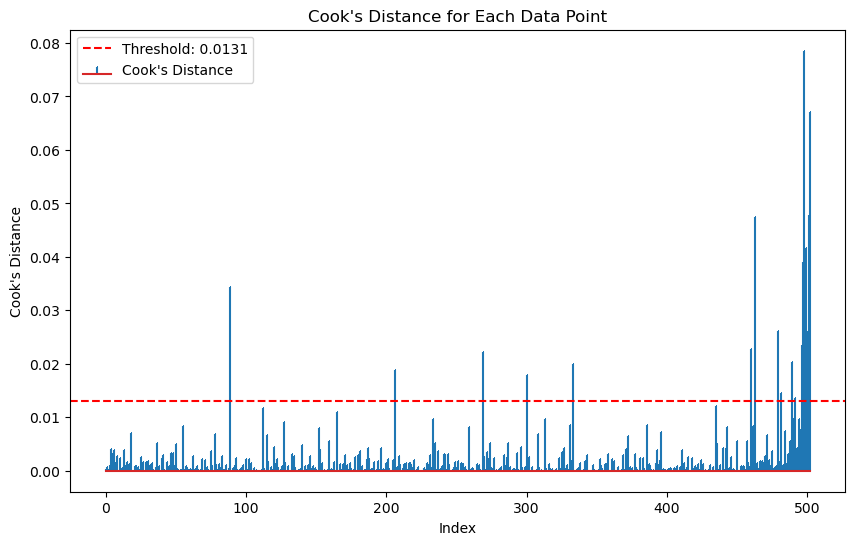

In [245]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / (316-9-1)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals_prediction.loc[y.index, 'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

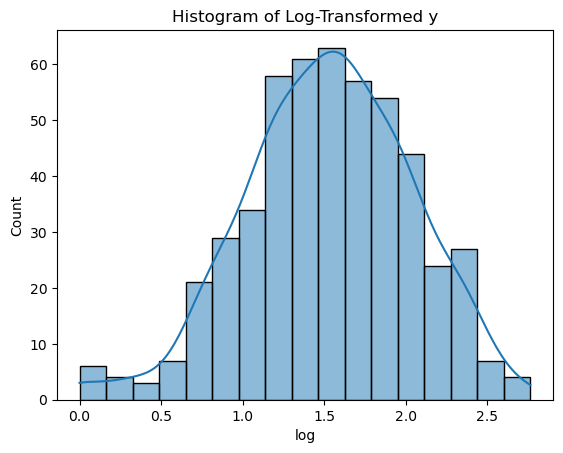

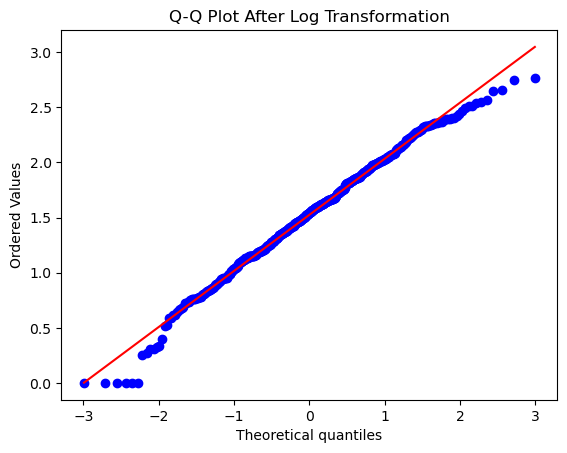

In [247]:
sns.histplot(merged_clutch_goals_prediction['log'], kde=True)
plt.title("Histogram of Log-Transformed y")
plt.show()

stats.probplot(merged_clutch_goals_prediction['log'], dist="norm", plot=plt)
plt.title("Q-Q Plot After Log Transformation")
plt.show()

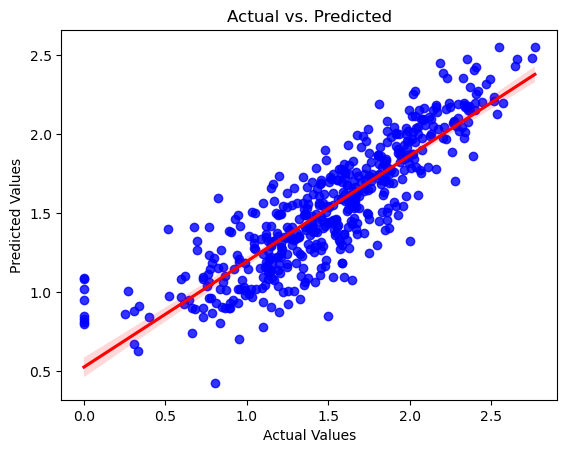

In [169]:
sns.regplot(data=merged_clutch_goals_prediction, x=merged_clutch_goals_prediction['log'], y=merged_clutch_goals_prediction['predicted_clutch_score'], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()